## Модели ARIMA и GARCH, прогнозирование значений на их основе

Выберите ряд из первого задания и постройте его модель ARIMA/GARCH. Отчет нужно будет оформить в jupyter-ноутбук.
Дополнительное задание: попробуйте спрогнозировать график классическим ML.

In [20]:
from scipy.stats import boxcox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
%matplotlib inline
from arch import arch_model

In [2]:
auto_registration = pd.read_csv("homework_monthly-us-auto-registration-tho.csv",sep=';')

Посмотрим, как выглядят наш нестанционарный ряд:

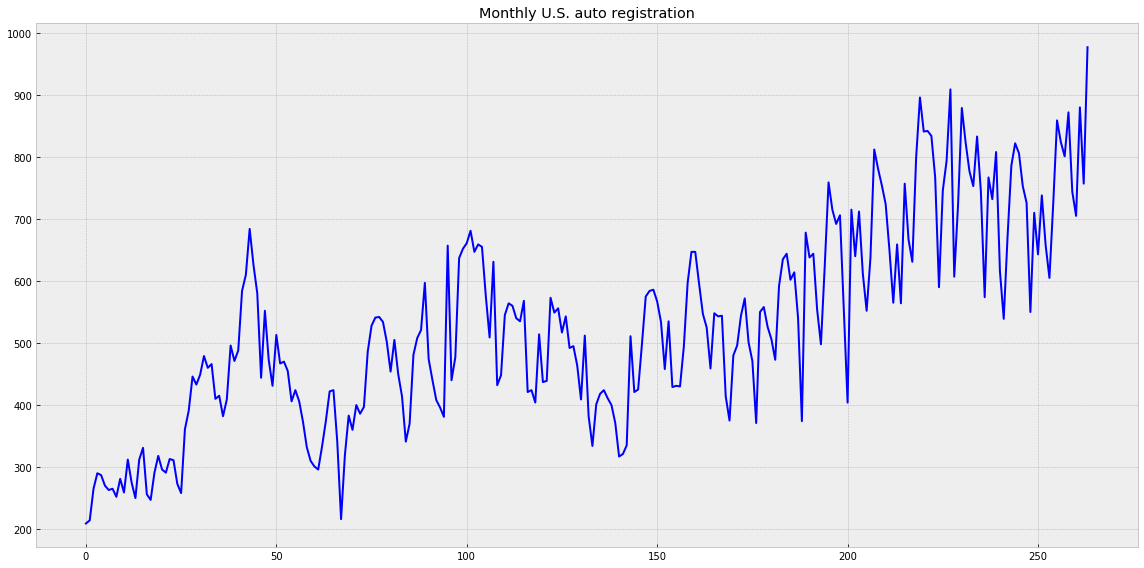

In [21]:
plt.figure(figsize=(16, 8))
layout = (3, 2)
ts_ax = plt.subplot()
auto_registration["Count"].plot(ax=ts_ax, color='blue')
ts_ax.set_title("Monthly U.S. auto registration")
plt.tight_layout()

In [15]:
train, test = auto_registration[:-12], auto_registration[-12:]

## Arima

In [5]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

D:\Netology\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Netology\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
D:\Netology\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Netology\Anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


aic: 2885.92436 | order: (2, 1, 3)
Results of Dickey-Fuller Test:
Test Statistic                  -4.380045
p-value                          0.000322
#Lags Used                      15.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


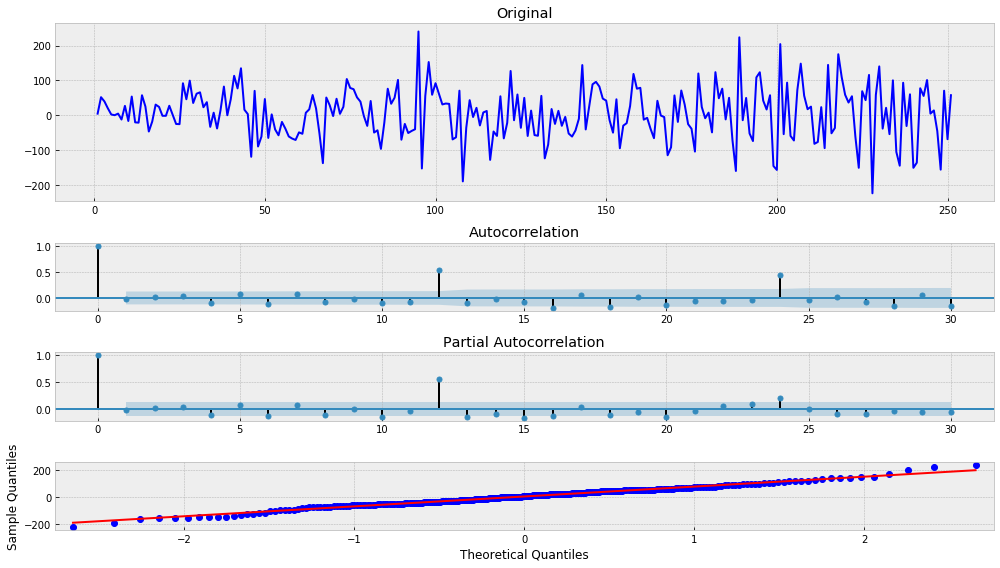

In [16]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(train["Count"], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

_ = tsplot(best_mdl.resid, lags=30)

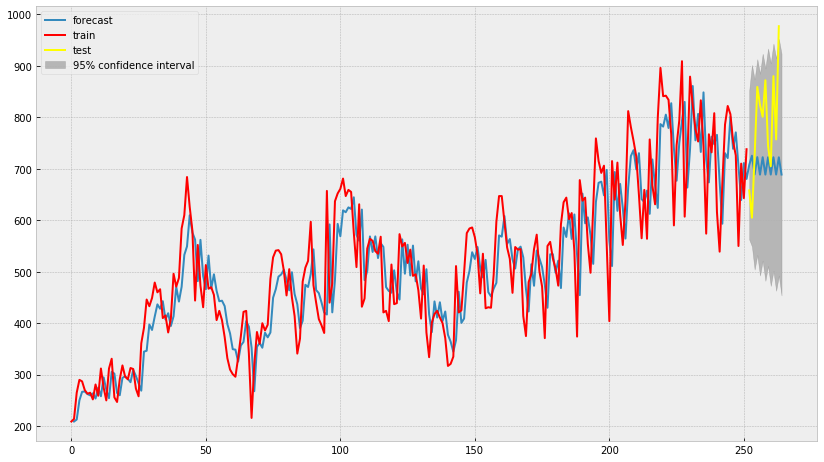

In [29]:
plt.figure(figsize=(14,8))
ax = plt.axes()
best_mdl.plot_predict(1, len(train["Count"])+12, plot_insample=False, ax=ax)
plt.plot(train["Count"], color='red', label='train')
plt.plot(test["Count"], color='yellow', label='test')
plt.legend()
plt.show()

В целом интревал предсказан неплохо, думаю проблема последней точки из-за того что в данной модели не убирается сезонность

## Garch

In [34]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(train["Count"], p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Count   R-squared:                      -0.030
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.030
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1570.11
Distribution:      Standardized Student's t   AIC:                           3158.23
Method:                  Maximum Likelihood   BIC:                           3189.99
                                              No. Observations:                  252
Date:                      Sun, Jun 02 2019   Df Residuals:                      243
Time:                              11:15:16   Df Model:                            9
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

Results of Dickey-Fuller Test:
Test Statistic                  -2.126195
p-value                          0.234113
#Lags Used                      14.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


D:\Netology\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


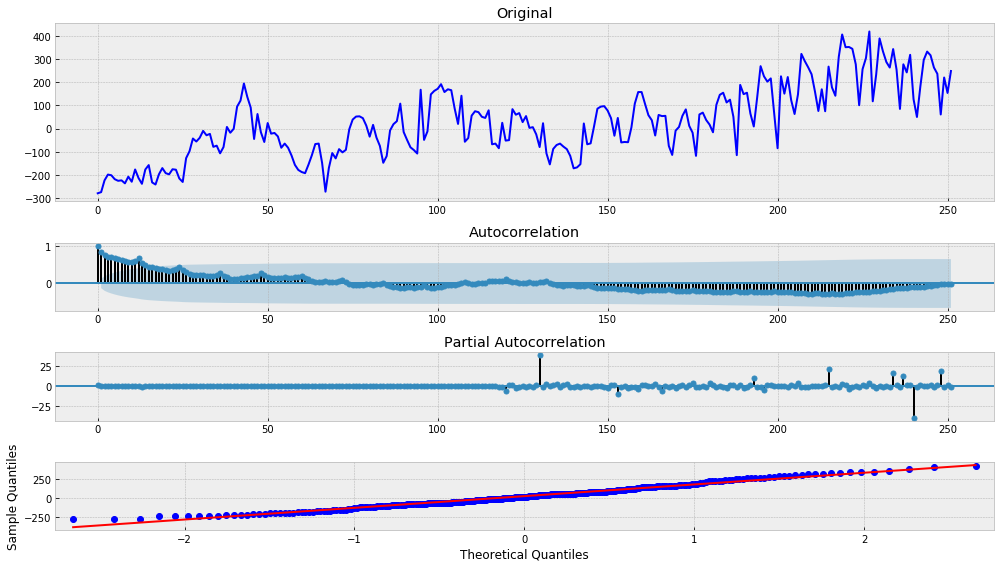

In [35]:
tsplot(res.resid)

p-value = 0.234113 > 0.05, сделаем ряд стационарным

In [42]:
series_auto_registration = auto_registration['Count'] 
series_auto_registration = boxcox(series_auto_registration, 0)
series_auto_registration = series_auto_registration[1:] - series_auto_registration[:-1]
series_auto_registration = series_auto_registration[12:] - series_auto_registration[:-12]

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


D:\Netology\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


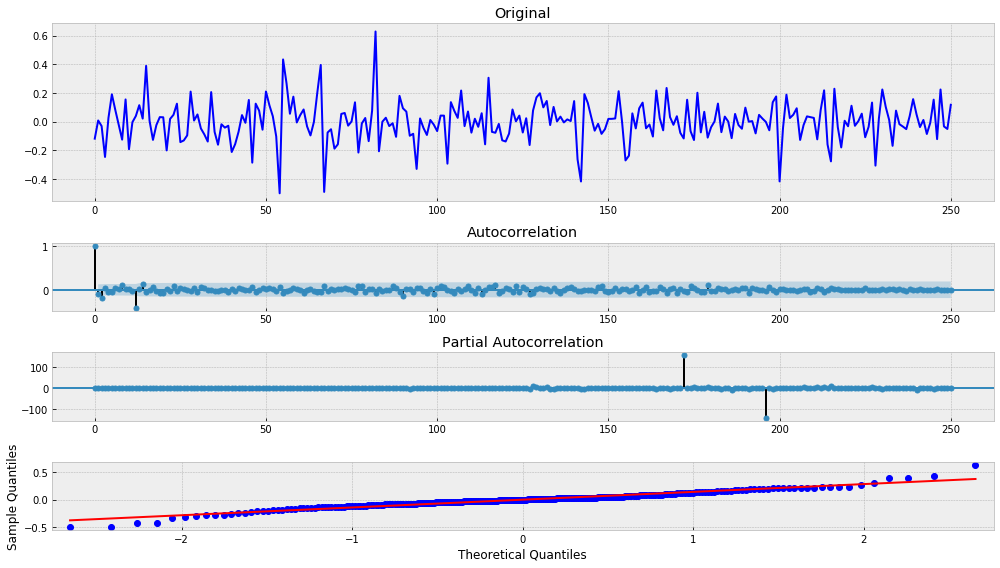

In [43]:
tsplot(series_auto_registration)

In [44]:
train, test = series_auto_registration[:-12], series_auto_registration[-12:]

In [62]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(train, p=p_, o=o_, q=q_, dist='StudentsT',vol='GARCH')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                143.530
Distribution:      Standardized Student's t   AIC:                          -269.061
Method:                  Maximum Likelihood   BIC:                          -237.772
                                              No. Observations:                  239
Date:                      Sun, Jun 02 2019   Df Residuals:                      230
Time:                              11:38:06   Df Model:                            9
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Results of Dickey-Fuller Test:
Test Statistic                -6.474725e+00
p-value                        1.339949e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64


D:\Netology\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


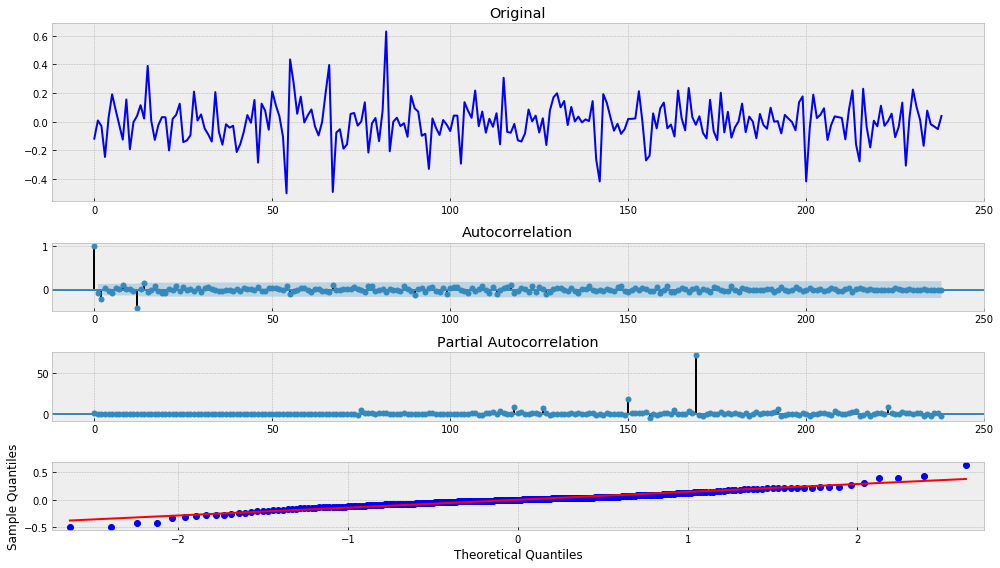

In [63]:
tsplot(res.resid)

## Классический ML

In [38]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.2):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [36]:
from sklearn.linear_model import LinearRegression

In [40]:
X_train, X_test, y_train, y_test = prepareData(auto_registration)
reg_predict = LinearRegression()
reg_predict.fit(X_train,y_train)
prediction = reg_predict.predict(X_test)

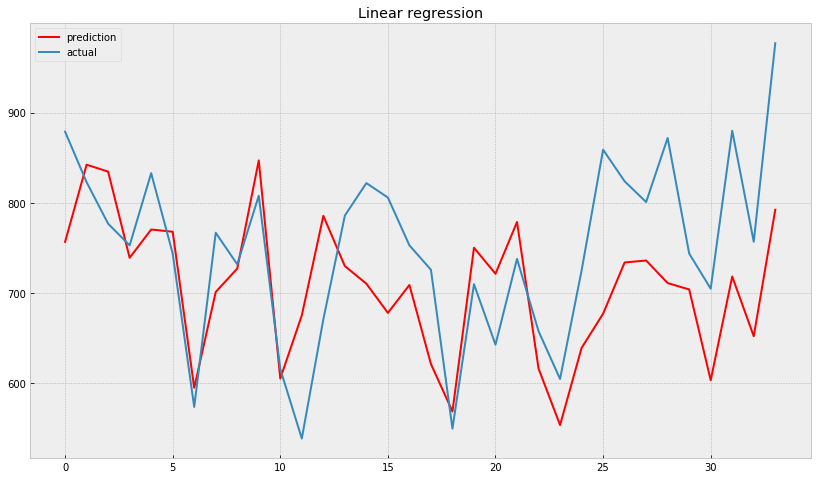

In [41]:
plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);